In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
## This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

PATH = "data/driver/"
sz=224
arch = resnet34
arch=resnext50
bs=32

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.backends.cudnn.enabled

True

In [5]:
!ls '{PATH}train'

c0  c1	c2  c3	c4  c5	c6  c7	c8  c9


In [6]:
os.listdir(PATH)

['sample_submission.csv',
 'test',
 'imgs.zip',
 'sample_submission.csv.zip',
 'driver_imgs_list.csv.zip',
 'driver_imgs_list.csv',
 'valid',
 'models',
 'train',
 'tmp',
 'driver_imgs_list_split.csv']

In [7]:
files = os.listdir(f'{PATH}valid/c8')[:10]
files

['img_102005.jpg',
 'img_50282.jpg',
 'img_73792.jpg',
 'img_5840.jpg',
 'img_7407.jpg',
 'img_57030.jpg',
 'img_35638.jpg',
 'img_39261.jpg',
 'img_89462.jpg',
 'img_92263.jpg']

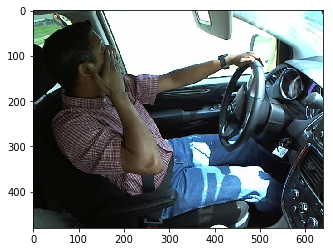

In [8]:
image = plt.imread(f'{PATH}valid/c8/{files[9]}')
plt.imshow(image);

In [10]:
os.listdir(f'{PATH}train/c7/')

['img_76462.jpg',
 'img_19793.jpg',
 'img_45037.jpg',
 'img_54586.jpg',
 'img_81866.jpg',
 'img_16215.jpg',
 'img_76185.jpg',
 'img_95055.jpg',
 'img_68102.jpg',
 'img_77360.jpg',
 'img_77108.jpg',
 'img_42640.jpg',
 'img_74538.jpg',
 'img_22594.jpg',
 'img_14430.jpg',
 'img_68868.jpg',
 'img_17270.jpg',
 'img_98947.jpg',
 'img_43444.jpg',
 'img_31104.jpg',
 'img_6484.jpg',
 'img_32618.jpg',
 'img_55557.jpg',
 'img_35424.jpg',
 'img_77499.jpg',
 'img_68377.jpg',
 'img_72334.jpg',
 'img_85227.jpg',
 'img_83419.jpg',
 'img_5609.jpg',
 'img_86086.jpg',
 'img_46863.jpg',
 'img_34364.jpg',
 'img_92000.jpg',
 'img_49792.jpg',
 'img_37922.jpg',
 'img_2015.jpg',
 'img_20781.jpg',
 'img_27689.jpg',
 'img_16985.jpg',
 'img_17889.jpg',
 'img_79504.jpg',
 'img_80158.jpg',
 'img_82992.jpg',
 'img_79771.jpg',
 'img_36387.jpg',
 'img_71360.jpg',
 'img_21218.jpg',
 'img_54858.jpg',
 'img_82451.jpg',
 'img_60767.jpg',
 'img_11047.jpg',
 'img_100683.jpg',
 'img_30189.jpg',
 'img_56205.jpg',
 'img_34046.

## Steps

1. Enable data augmentation, and precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting

In [11]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz, aug_tfms = transforms_side_on, max_zoom= 1.1),
                                     test_name = 'test', num_workers = 4,
                                     bs = bs)
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 2492/2492 [09:00<00:00,  4.61it/s]


In [12]:
learn.lr_find()

 76%|███████▌  | 423/556 [00:04<00:01, 85.25it/s, loss=2.76] 


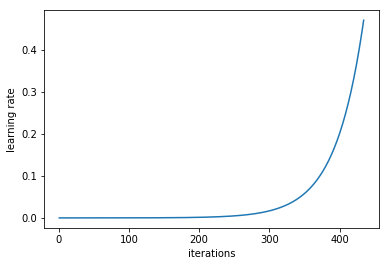

In [13]:
learn.sched.plot_lr()

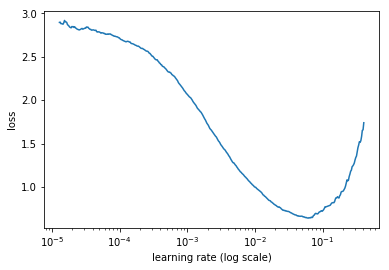

In [14]:
learn.sched.plot()

In [17]:
lr = 1e-2

In [15]:
learn.fit(1e-2, 5)

epoch      trn_loss   val_loss   accuracy                     
    0      0.18641    2.255111   0.451023  
    1      0.091652   2.482737   0.451023                      
    2      0.067545   2.590963   0.447578                     
    3      0.064402   2.549757   0.440904                     
    4      0.043199   2.584767   0.449085                     



[array([2.58477]), 0.44908503767812724]

In [41]:
learn.precompute = False

In [16]:
learn.fit(1e-2, 3, cycle_len = 1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.040647   2.773446   0.429709  
    1      0.035701   2.652213   0.450592                     
    2      0.034562   2.647925   0.436598                     



[array([2.64793]), 0.43659849300964526]

In [18]:
lrs = np.array([lr*1e-2,lr*1e-1,lr])

In [19]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.258271   2.033389   0.52422   
    1      0.250475   2.045932   0.513671                    
    2      0.181518   1.812801   0.538644                    
    3      0.205369   1.770565   0.538213                    
    4      0.156567   1.830325   0.550484                    
    5      0.159325   1.7631     0.559742                    
    6      0.131517   1.769651   0.55479                     



[array([1.76965]), 0.5547900968847799]

In [21]:
learn.lr_find()

 69%|██████▉   | 386/556 [01:13<00:32,  5.24it/s, loss=0.464]

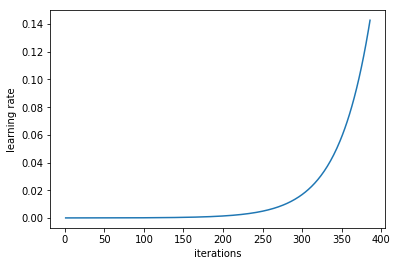

In [24]:
learn.sched.plot_lr()

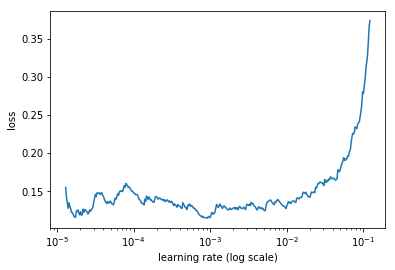

In [25]:
learn.sched.plot()

In [26]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.141232   1.686566   0.570506  
    1      0.144368   1.705934   0.56577                     
    2      0.145039   1.62921    0.581055                    
    3      0.129163   1.875895   0.530678                    
    4      0.136302   1.700331   0.55436                     
    5      0.109794   1.681264   0.561033                     
    6      0.100882   1.694579   0.558019                     


[array([1.69458]), 0.5580193756791824]

In [27]:
learn.save('224_pre')

In [28]:
learn.load('224_pre')

In [29]:
log_preds,y = learn.TTA()

### Scoring

In [31]:
test_preds = learn.predict(is_test = True)

In [33]:
test_preds.shape

(79726, 10)

In [36]:
test_preds_exp = np.exp(test_preds)

In [37]:
test_preds_exp.shape

(79726, 10)

In [38]:
test_preds_exp[:5]

array([[0.29955, 0.27548, 0.00002, 0.00009, 0.00314, 0.28054, 0.00005, 0.00003, 0.05892, 0.08217],
       [0.02875, 0.00029, 0.00011, 0.00005, 0.00029, 0.89592, 0.00004, 0.00437, 0.01102, 0.05917],
       [0.00001, 0.00025, 0.     , 0.     , 0.     , 0.     , 0.     , 0.99959, 0.00008, 0.00006],
       [0.59442, 0.     , 0.00002, 0.0013 , 0.30124, 0.01174, 0.00008, 0.06281, 0.02479, 0.00359],
       [0.00121, 0.05315, 0.00801, 0.00011, 0.00014, 0.00775, 0.0063 , 0.0023 , 0.78736, 0.13368]],
      dtype=float32)

In [39]:
import pandas as pd

In [40]:
columns = pd.read_csv('~/data/driver/sample_submission.csv', index_col='img').columns

In [41]:
test_submission = pd.DataFrame(test_preds_exp)

In [54]:
# test_submission.index = [i.split('.jpg')[0] for i in os.listdir(f'{PATH}/test')]

NameError: name 'test_submission_attemp' is not defined

In [52]:
test_submission.index = [i for i in os.listdir(f'{PATH}/test')]

In [53]:
test_submission.index

Index(['img_37990.jpg', 'img_79092.jpg', 'img_55859.jpg', 'img_92870.jpg',
       'img_20844.jpg', 'img_46378.jpg', 'img_43222.jpg', 'img_41999.jpg',
       'img_44458.jpg', 'img_3738.jpg',
       ...
       'img_21380.jpg', 'img_60814.jpg', 'img_66651.jpg', 'img_14568.jpg',
       'img_83587.jpg', 'img_43669.jpg', 'img_266.jpg', 'img_58081.jpg',
       'img_38534.jpg', 'img_76046.jpg'],
      dtype='object', length=79726)

In [55]:
test_submission.index.name = 'img'

In [56]:
test_submission.to_csv("~/data/driver/submission_20180522.csv", header = columns)

In [57]:
! head -2 ~/data/driver/submission_20180522.csv

img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
img_37990.jpg,0.29955357,0.27548298,1.8062943e-05,9.254928e-05,0.0031382137,0.28054386,5.2510273e-05,2.7742999e-05,0.058921743,0.082169056


In [58]:
test_submission.head()

,0,1,2,3,4,5,6,7,8,9
img,,,,,,,,,,
img_37990.jpg,0.299554,0.275483,1.806294e-05,9.254928e-05,3.138214e-03,0.280544,5.251027e-05,0.000028,0.058922,0.082169
img_79092.jpg,0.028745,0.000291,1.097191e-04,5.330953e-05,2.912474e-04,0.895916,3.825465e-05,0.004373,0.011018,0.059165
img_55859.jpg,0.000005,0.000255,4.877371e-07,7.218668e-09,5.355544e-09,0.000005,3.925727e-08,0.999589,0.000082,0.000064
img_92870.jpg,0.594418,0.000002,2.395070e-05,1.303015e-03,3.012404e-01,0.011737,7.918115e-05,0.062810,0.024793,0.003594
img_20844.jpg,0.001211,0.053148,8.010982e-03,1.117062e-04,1.368871e-04,0.007749,6.299728e-03,0.002297,0.787356,0.133679


In [42]:
test_submission.head()

,0,1,2,3,4,5,6,7,8,9
0,0.299554,0.275483,1.806294e-05,9.254928e-05,3.138214e-03,0.280544,5.251027e-05,0.000028,0.058922,0.082169
1,0.028745,0.000291,1.097191e-04,5.330953e-05,2.912474e-04,0.895916,3.825465e-05,0.004373,0.011018,0.059165
2,0.000005,0.000255,4.877371e-07,7.218668e-09,5.355544e-09,0.000005,3.925727e-08,0.999589,0.000082,0.000064
3,0.594418,0.000002,2.395070e-05,1.303015e-03,3.012404e-01,0.011737,7.918115e-05,0.062810,0.024793,0.003594
4,0.001211,0.053148,8.010982e-03,1.117062e-04,1.368871e-04,0.007749,6.299728e-03,0.002297,0.787356,0.133679


In [40]:
# label_df = pd.read_csv("data/dogbreed/labels.csv")